In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
# Load the dataset
df_inf = pd.read_csv("/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv")
df_woinf = pd.read_excel("/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx",sheet_name="Full_new")

In [3]:
#Merge the files
data = pd.merge(df_woinf, df_inf, on='Patient File No.', suffixes=('', '_wo'), how='left')
#Drop repeated features
data =data.drop(['Unnamed: 44', 'Sl. No_wo', 'PCOS (Y/N)_wo', '  I   beta-HCG(mIU/mL)_wo',
       'II    beta-HCG(mIU/mL)_wo', 'AMH(ng/mL)_wo'], axis=1)
#Change the title of the properties
data = data.rename(columns = {"PCOS (Y/N)":"Target"})
#Look at the merged data.
data.head() 

,Sl. No,Patient File No.,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   Target                  541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [5]:
# Drop unnecessary columns (adjust according to dataset)
data = data.drop(['Patient File No.'], axis=1)


In [6]:
# Step 3: Label Encoding for Categorical Variables
for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

In [7]:
# Step 4: Handle Missing Values
imputer = SimpleImputer(strategy='median')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

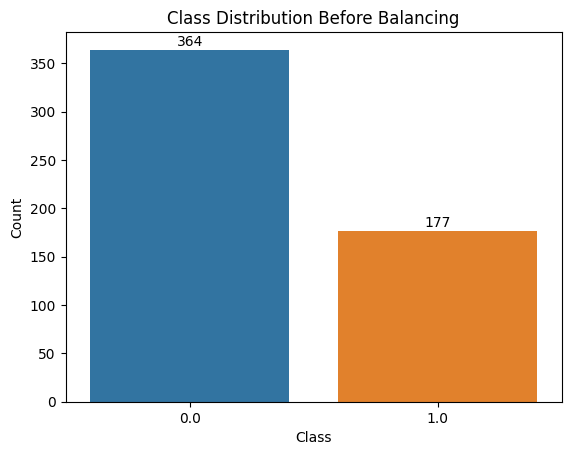

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot
sns.countplot(x='Target', data=data)
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class')
plt.ylabel('Count')


for p in plt.gca().patches:
    count = int(p.get_height())
    plt.text(p.get_x() + p.get_width() / 2., count + 1,  
             str(count), ha='center', va='bottom')       

plt.show()


In [9]:
# Select relevant features and target variable
X = data.drop(columns=['Target'])  # Features
y = data['Target']  # Target variable

In [10]:
# Step 7: Resample using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


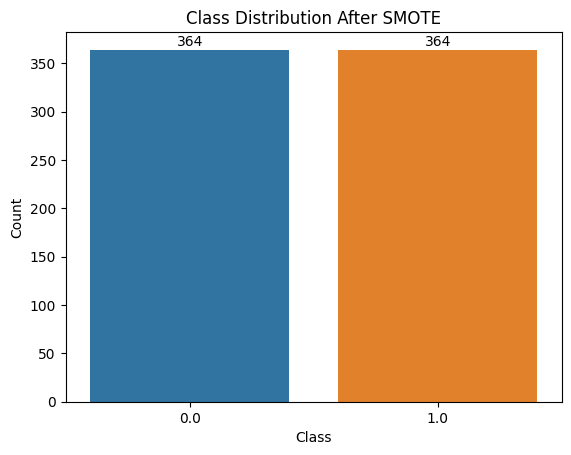

In [11]:
# Step 8: Visualize Class Distribution After Resampling
sns.countplot(x=y_res)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# Show count on top of each bar
for p in plt.gca().patches:
    count = int(p.get_height())
    plt.text(p.get_x() + p.get_width() / 2., count + 1, 
             str(count), ha='center', va='bottom')

plt.show()

In [12]:
"""# Step 9: Feature Selection using RFE
estimator = RandomForestClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=30)
X_selected = selector.fit_transform(X_res, y_res)
"""

'# Step 9: Feature Selection using RFE\nestimator = RandomForestClassifier(random_state=42)\nselector = RFE(estimator, n_features_to_select=30)\nX_selected = selector.fit_transform(X_res, y_res)\n'

In [13]:
# Step 10: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [14]:

# Step 11: Train Individual Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}


Model: Random Forest
Accuracy: 0.9452054794520548
Precision: 0.9452054794520548
Recall: 0.9452054794520548
F1 Score: 0.9452054794520548
AUC: 0.9452054794520548

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        73
         1.0       0.95      0.95      0.95        73

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146



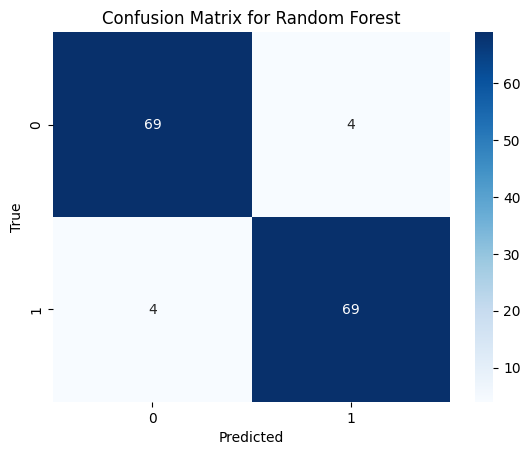


Model: Naive Bayes
Accuracy: 0.910958904109589
Precision: 0.8571428571428571
Recall: 0.9863013698630136
F1 Score: 0.9171974522292993
AUC: 0.910958904109589

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90        73
         1.0       0.86      0.99      0.92        73

    accuracy                           0.91       146
   macro avg       0.92      0.91      0.91       146
weighted avg       0.92      0.91      0.91       146



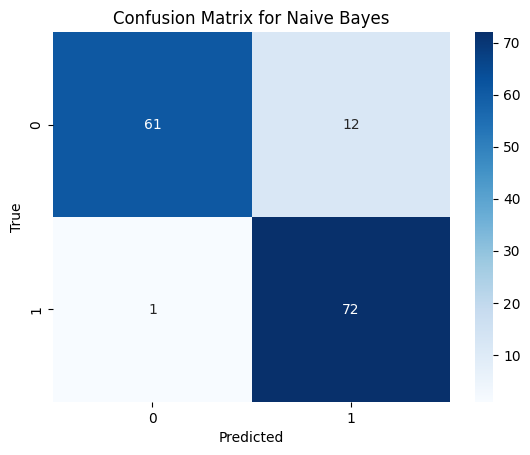


Model: XGBoost
Accuracy: 0.952054794520548
Precision: 0.9583333333333334
Recall: 0.9452054794520548
F1 Score: 0.9517241379310345
AUC: 0.9520547945205481

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95        73
         1.0       0.96      0.95      0.95        73

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146



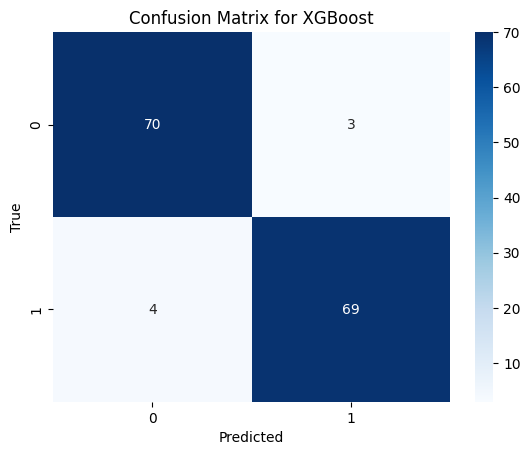


Model: AdaBoost
Accuracy: 0.9315068493150684
Precision: 0.9090909090909091
Recall: 0.958904109589041
F1 Score: 0.9333333333333333
AUC: 0.9315068493150684

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93        73
         1.0       0.91      0.96      0.93        73

    accuracy                           0.93       146
   macro avg       0.93      0.93      0.93       146
weighted avg       0.93      0.93      0.93       146



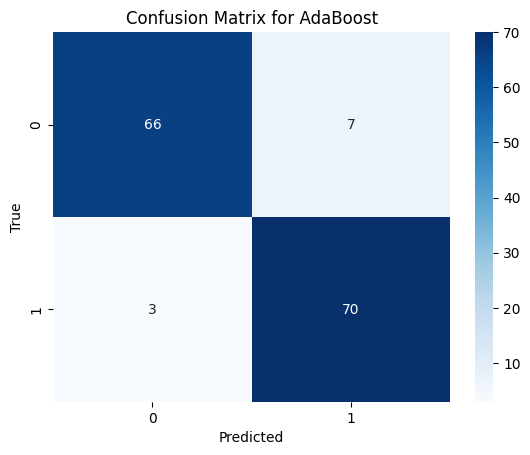

In [15]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [16]:
# Step 12: Train Stacking Classifier
stack_models = [
    ('rf', models['Random Forest']),
    ('nb', models['Naive Bayes']),
    ('xgb', models['XGBoost']),
    ('ada', models['AdaBoost'])
]
meta = RandomForestClassifier(random_state=42)
stacking_model = StackingClassifier(estimators=stack_models, final_estimator=meta, cv=5)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)


Model: Stacking Classifier
Accuracy: 0.9452054794520548
Precision: 0.9577464788732394
Recall: 0.9315068493150684
F1 Score: 0.9444444444444444
AUC: 0.9452054794520548

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95        73
         1.0       0.96      0.93      0.94        73

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146



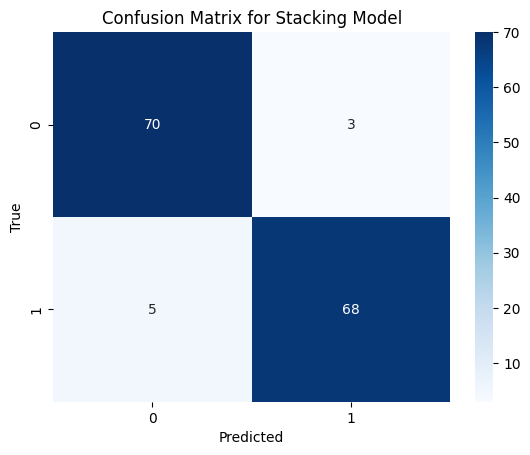

In [17]:
# Step 13: Evaluate Stacking Model
print("\nModel: Stacking Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

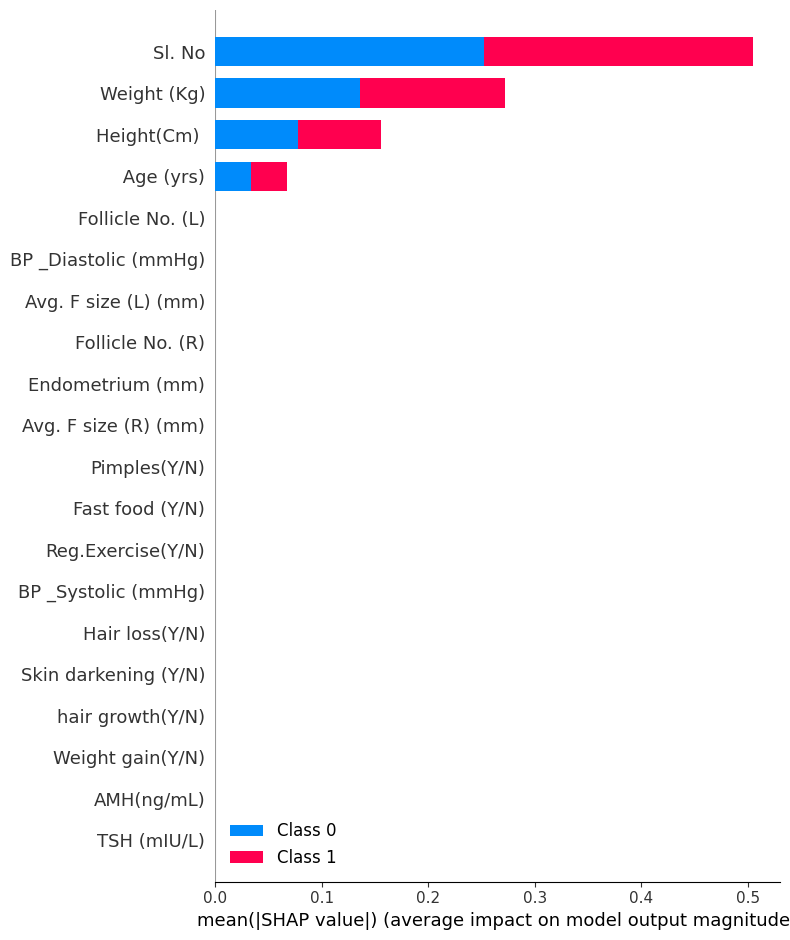

In [18]:
# Step 14: Explainability using SHAP
explainer = shap.TreeExplainer(stacking_model.final_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [19]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [21]:
# Print results
print(f'Accuracy: {accuracy:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.95
ROC AUC Score: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        73
         1.0       0.95      0.95      0.95        73

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146

